In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbn
import datetime
from pandas.plotting import scatter_matrix
%matplotlib inline

## Getting the columns and building a dtype dictionary

In [2]:
columns = pd.read_csv('/Volumes/thesis-data/main.csv', nrows=1).columns

x = {'ADM_MET': 'object', 'DIS_MET': 'object', 'ADM_SOU': 'object',
    'MAIN_SPEC': 'object', 'NON_NHS_FLAG': 'object', 
    'OPCS_12': 'object', 'OPCS_13': 'object', 'DIAG_NO': 'int', 
    'PROC_NO': 'int', 'Age': 'int', 'DayofMainProc': 'object', 
    'SEX': 'object', 'consultant': 'object', 'end_ward': 'object', 
    'pasid': 'object', 'practice_code': 'object', 'procedure_code': 'object', 
    'site1': 'object', 'south_north': 'object', 'start_ward': 'object', 
    'end_ward': 'object', '100x': 'object', '10x': 'object', '5x': 'object', 
    '2x': 'object', 'ACTIVITY': 'object', 'C.DIFF': 'object', 
    'MRSA': 'object', 'Obese': 'object', 'NON_NHS_FLG': 'object', 
    'SPECIALTY': 'object', 'ACUITY': 'object', 'SS_CODE': 'object', 
    'WIP_FLG': 'object', 'SPELL_FLG': 'object', 'INTERNAL_ID': 'object'}

primsec = [col for col in columns if col.endswith('Prim') or col.endswith('Sec') or col.endswith('.1')]
y = {col: 'object' for col in primsec}

dtype_dict = {**x, **y}
dates = ['Bench_Period', 'Period', 'ADMDATE', 'DISCDATE', 'EPISODE_ST', 'EPISODE_END', 'procedure_date_dt']

## Reading in the whole dataset

In [3]:
chunksize = 300000
chunks = []
for chunk in pd.read_csv(
                '/Volumes/thesis-data/main.csv', 
                parse_dates=dates, dtype=dtype_dict, 
                chunksize=chunksize
             ):
    chunks.append(chunk)

df = pd.concat(chunks)

#### We have 2,447,475 episodes described by 259 attributes of which there are 865,430 individual patients and separate spells:

In [5]:
df.shape, df.PATIENT_ID.nunique(), df.SPELL_ID.nunique()

((2447475, 259), 865430, 1946597)

#### Note that in this dataset there are a number of categorical attributes with a large range of values. For instance, we have:
- 1082 GP practices
- 1468 HRGs (Healthcare Resource Groups)
- 7747 primary diagnoses (ICD10)
- 4751 primary procedures (OPCS10)

In [6]:
df.practice_code.nunique(), df.HRG.nunique(), df.ICD10.nunique(), df.OPCS4.nunique()

(1082, 1468, 7747, 4751)

#### So, we will reduce our dataset's attributes to include:
- personal identifiers (IDs, sex, age, origin, etc.)
- cost components
- non-specific clinical attributes (number of diagnoses, length of stay, HRG subchapter, obesity, admission method, elective/non-elective, etc.)

#### We will also remove specific clinical attributes such as:
- diagnosis codes
- particular HRGs
- procedure codes
- comorbidities

From this reduced dataset, we will carry out some initial descriptive data analysis that can be used for some elementary statistical inference later on. Obviously, work is needed to reduce the number of categorical values by means of clustering or in the case of GP practices, say, we could group them by their locality after they are decoded. This grouping would also make for a nice collection of graphs in the future using `geopandas`.

In [4]:
HRG_OPCS_ICD_Prog_cols = ['HRG'] + [col for col in columns if col.startswith('OPCS_') or col.startswith('ICD_') or col.startswith('Programme')]
severity = ['2x', '5x', '10x', '100x']

undesired_cols = ['LOAD_DATE'] + HRG_OPCS_ICD_Prog_cols + severity + primsec

In [8]:
[c for c in columns]

['100x',
 '10x',
 '2x',
 '5x',
 'ACTIVITY',
 'ACUITY',
 'ADMDATE',
 'ADM_MET',
 'ADM_SOU',
 'AMIPrim',
 'AMISec',
 'Age',
 'AsthmaPrim',
 'AsthmaSec',
 'BLD',
 'Bench_Period',
 'BldPrim',
 'BldSec',
 'BurnsPrim',
 'BurnsSec',
 'C.DIFF',
 'CC_LOS',
 'CHDPrim',
 'CHDSec',
 'CHFPrim',
 'CHFSec',
 'CNST',
 'COND_FLG',
 'COST',
 'CRIT',
 'CTDPrim',
 'CTDSec',
 'CVAPrim',
 'CVASec',
 'CanPrim',
 'CanSec',
 'CancerPrim',
 'CancerSec',
 'CerebrovascularPrim',
 'CerebrovascularSec',
 'ChronPainPrim',
 'ChronPainSec',
 'DC',
 'DIAG_NO',
 'DIAG_NO_WEI',
 'DIRECT',
 'DISCDATE',
 'DIS_DES',
 'DIS_MET',
 'DOM_LEVEL',
 'DOM_PROC',
 'DRUG',
 'DRUG_CHEMO',
 'DUMMY_TRUST',
 'DayofMainProc',
 'Dayofweek',
 'DemPrim',
 'DemSec',
 'DentPrim',
 'DentSec',
 'DiabPrim',
 'DiabSec',
 'DiabcompPrim',
 'DiabcompSec',
 'DiabetesPrim',
 'DiabetesSec',
 'EL',
 'EMER',
 'ENDO',
 'ENDO_TIME',
 'EPISODE_END',
 'EPISODE_ID',
 'EPISODE_ST',
 'EndocPrim',
 'EndocSec',
 'GUPrim',
 'GUSec',
 'GastroPrim',
 'GastroSec',
 'G

In [5]:
costs = [
    'NetCost', 'CRIT', 'EMER', 'IMG', 'MED', 'NCI', 
    'NID', 'OPTH', 'OTH', 'OUTP', 'PATH', 'PHAR', 
    'PROS', 'SPS', 'THER', 'WARD', 'BLD', 'ENDO', 
    'OCLST', 'OVH', 'RADTH', 'HCD', 'CNST', 'DRUG', 'SECC'
]

# Summative statistics

In [6]:
gb_data = df.groupby(['PATIENT_ID', 'SPELL_ID'], as_index=True)

In [7]:
gb_data = gb_data[['Bench_Period', 'LOS', 'PROC_NO', 'DIAG_NO'] + costs]

In [8]:
gb_data = gb_data.sum()

In [13]:
df.Age.describe()

count    2.447475e+06
mean     5.395587e+01
std      2.583542e+01
min      0.000000e+00
25%      3.300000e+01
50%      5.900000e+01
75%      7.500000e+01
max      1.090000e+02
Name: Age, dtype: float64

In [14]:
gb_data.describe()

,LOS,PROC_NO,DIAG_NO,NetCost,CRIT,EMER,IMG,MED,NCI,NID,...,WARD,BLD,ENDO,OCLST,OVH,RADTH,HCD,CNST,DRUG,SECC
count,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,...,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06
mean,3.517798e+00,1.896260e+00,4.926303e+00,1.744176e+03,9.239848e+01,1.243401e+00,3.272708e+01,3.473056e+02,-3.092653e+01,9.491878e+01,...,4.975510e+02,2.066881e+00,2.118579e+01,1.332378e+01,3.551482e+02,6.516310e-01,2.092264e+01,1.722796e+00,7.547894e+01,8.704666e-01
std,8.689961e+00,2.205943e+00,6.927091e+00,3.195509e+03,1.338350e+03,2.913163e+01,1.437745e+02,7.419361e+02,8.584253e+01,2.484178e+02,...,1.240424e+03,3.719332e+01,9.275810e+01,5.923555e+01,7.362845e+02,8.007478e+00,2.111123e+02,6.893361e+00,3.161319e+02,2.741932e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,4.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.296021e+04,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.700000e-01,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,3.473373e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.445000e+01,-2.975000e+01,1.499449e+01,...,1.033000e+01,0.000000e+00,0.000000e+00,0.000000e+00,8.486000e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.190000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00,3.000000e+00,7.473911e+02,0.000000e+00,0.000000e+00,8.000000e-02,1.306865e+02,-1.164000e+01,3.226000e+01,...,1.420900e+02,0.000000e+00,0.000000e+00,7.700000e-01,1.394900e+02,0.000000e+00,2.300000e-01,0.000000e+00,2.003000e+01,0.000000e+00
75%,2.000000e+00,3.000000e+00,6.000000e+00,1.863420e+03,0.000000e+00,0.000000e+00,1.093096e+01,3.754300e+02,-3.023272e+00,8.336000e+01,...,4.633700e+02,1.500000e-01,0.000000e+00,5.427239e+00,3.211200e+02,0.000000e+00,4.831911e+00,1.124207e+00,5.990000e+01,0.000000e+00
max,3.660000e+03,7.000000e+01,4.550000e+02,3.691689e+05,2.500006e+05,3.334789e+04,4.670866e+04,1.164499e+05,0.000000e+00,8.437421e+04,...,2.038541e+05,1.376871e+04,1.185595e+04,1.235837e+04,1.064286e+05,2.276410e+02,9.441185e+04,1.179190e+03,6.343052e+04,2.177736e+03


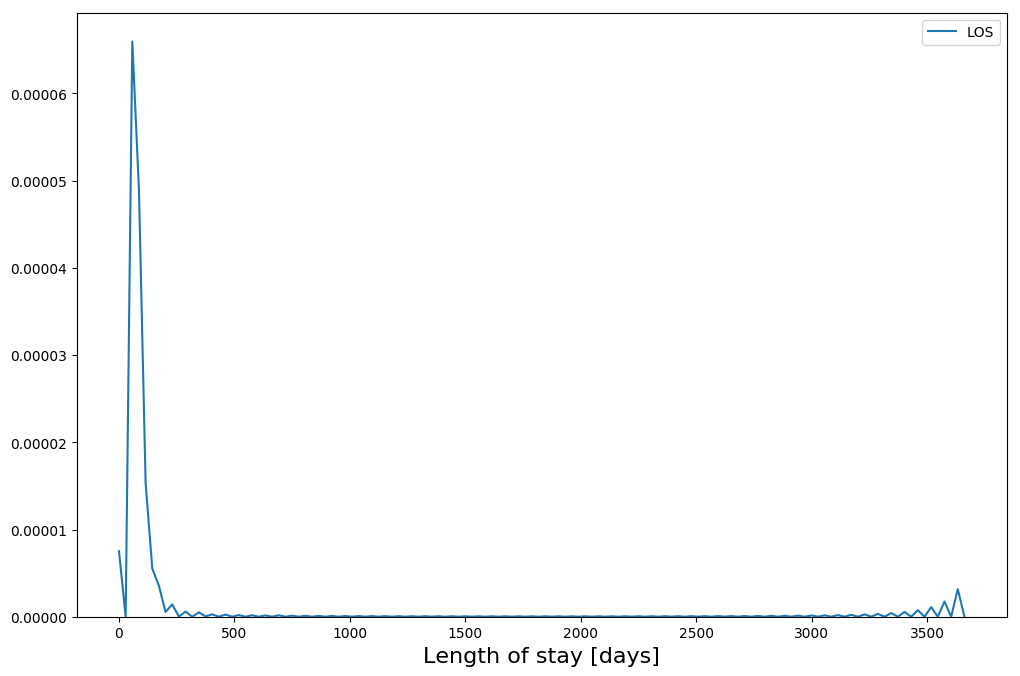

In [15]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(gb_data.LOS)
plt.xlabel('Length of stay [days]', size=16)
plt.savefig('../tex/img/LOS-kde.pdf');

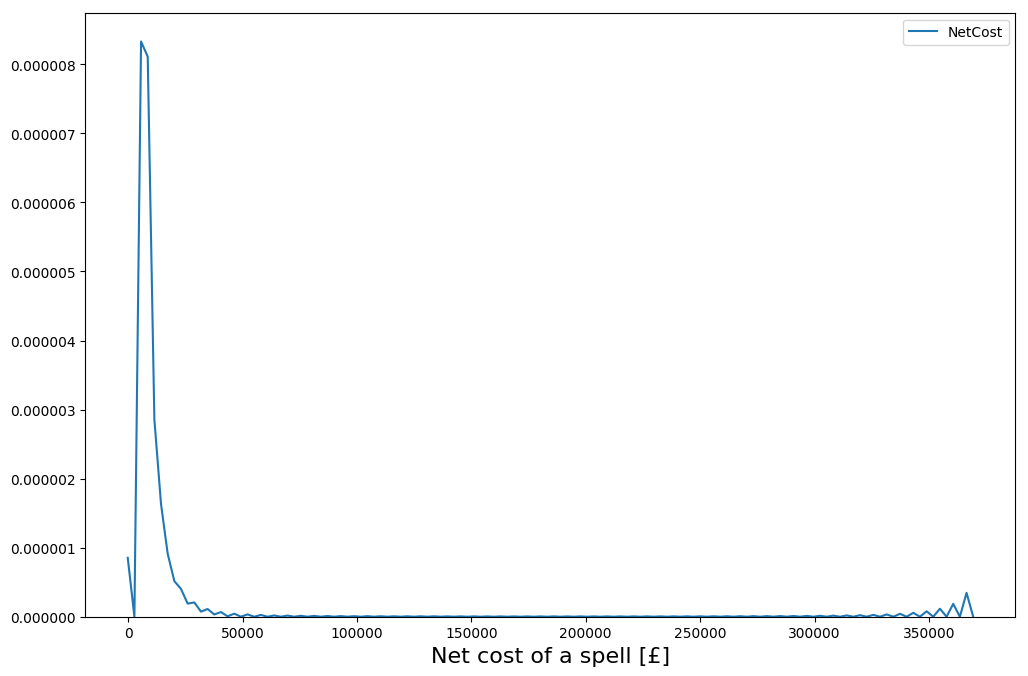

In [16]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(gb_data.NetCost)
plt.xlabel('Net cost of a spell [£]', size=16)
plt.savefig('../tex/img/NetCost-kde.pdf');

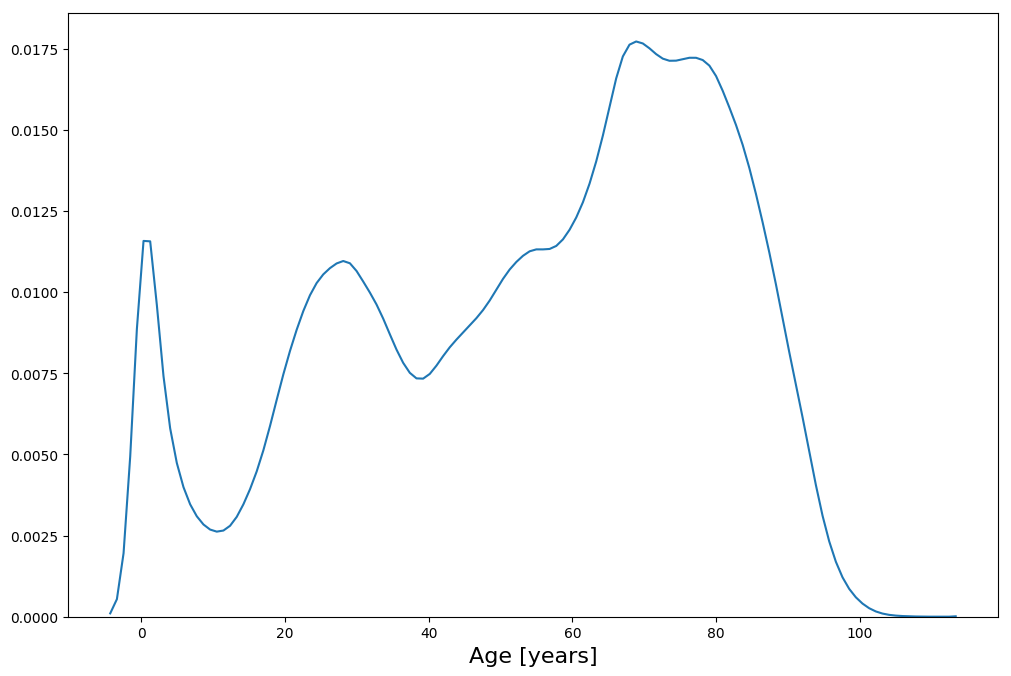

In [17]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df.Age, legend=False)
plt.xlabel('Age [years]', size=16)
plt.savefig('../tex/img/Age-kde.pdf');

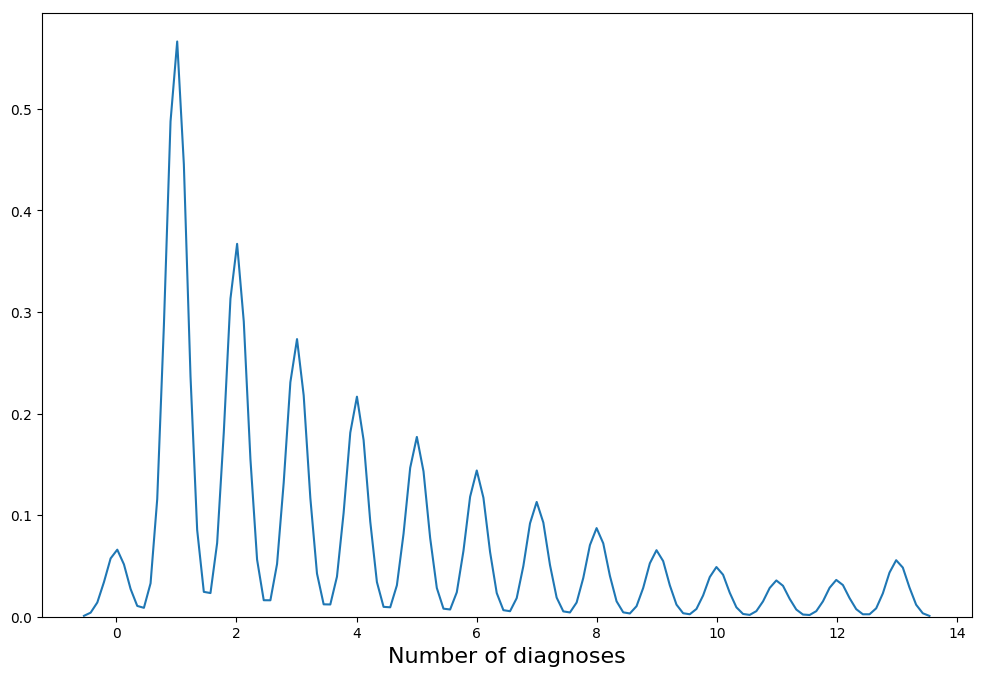

In [18]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df.DIAG_NO, legend=False)
plt.xlabel('Number of diagnoses', size=16)
plt.savefig('../tex/img/DIAG_NO-kde.pdf');

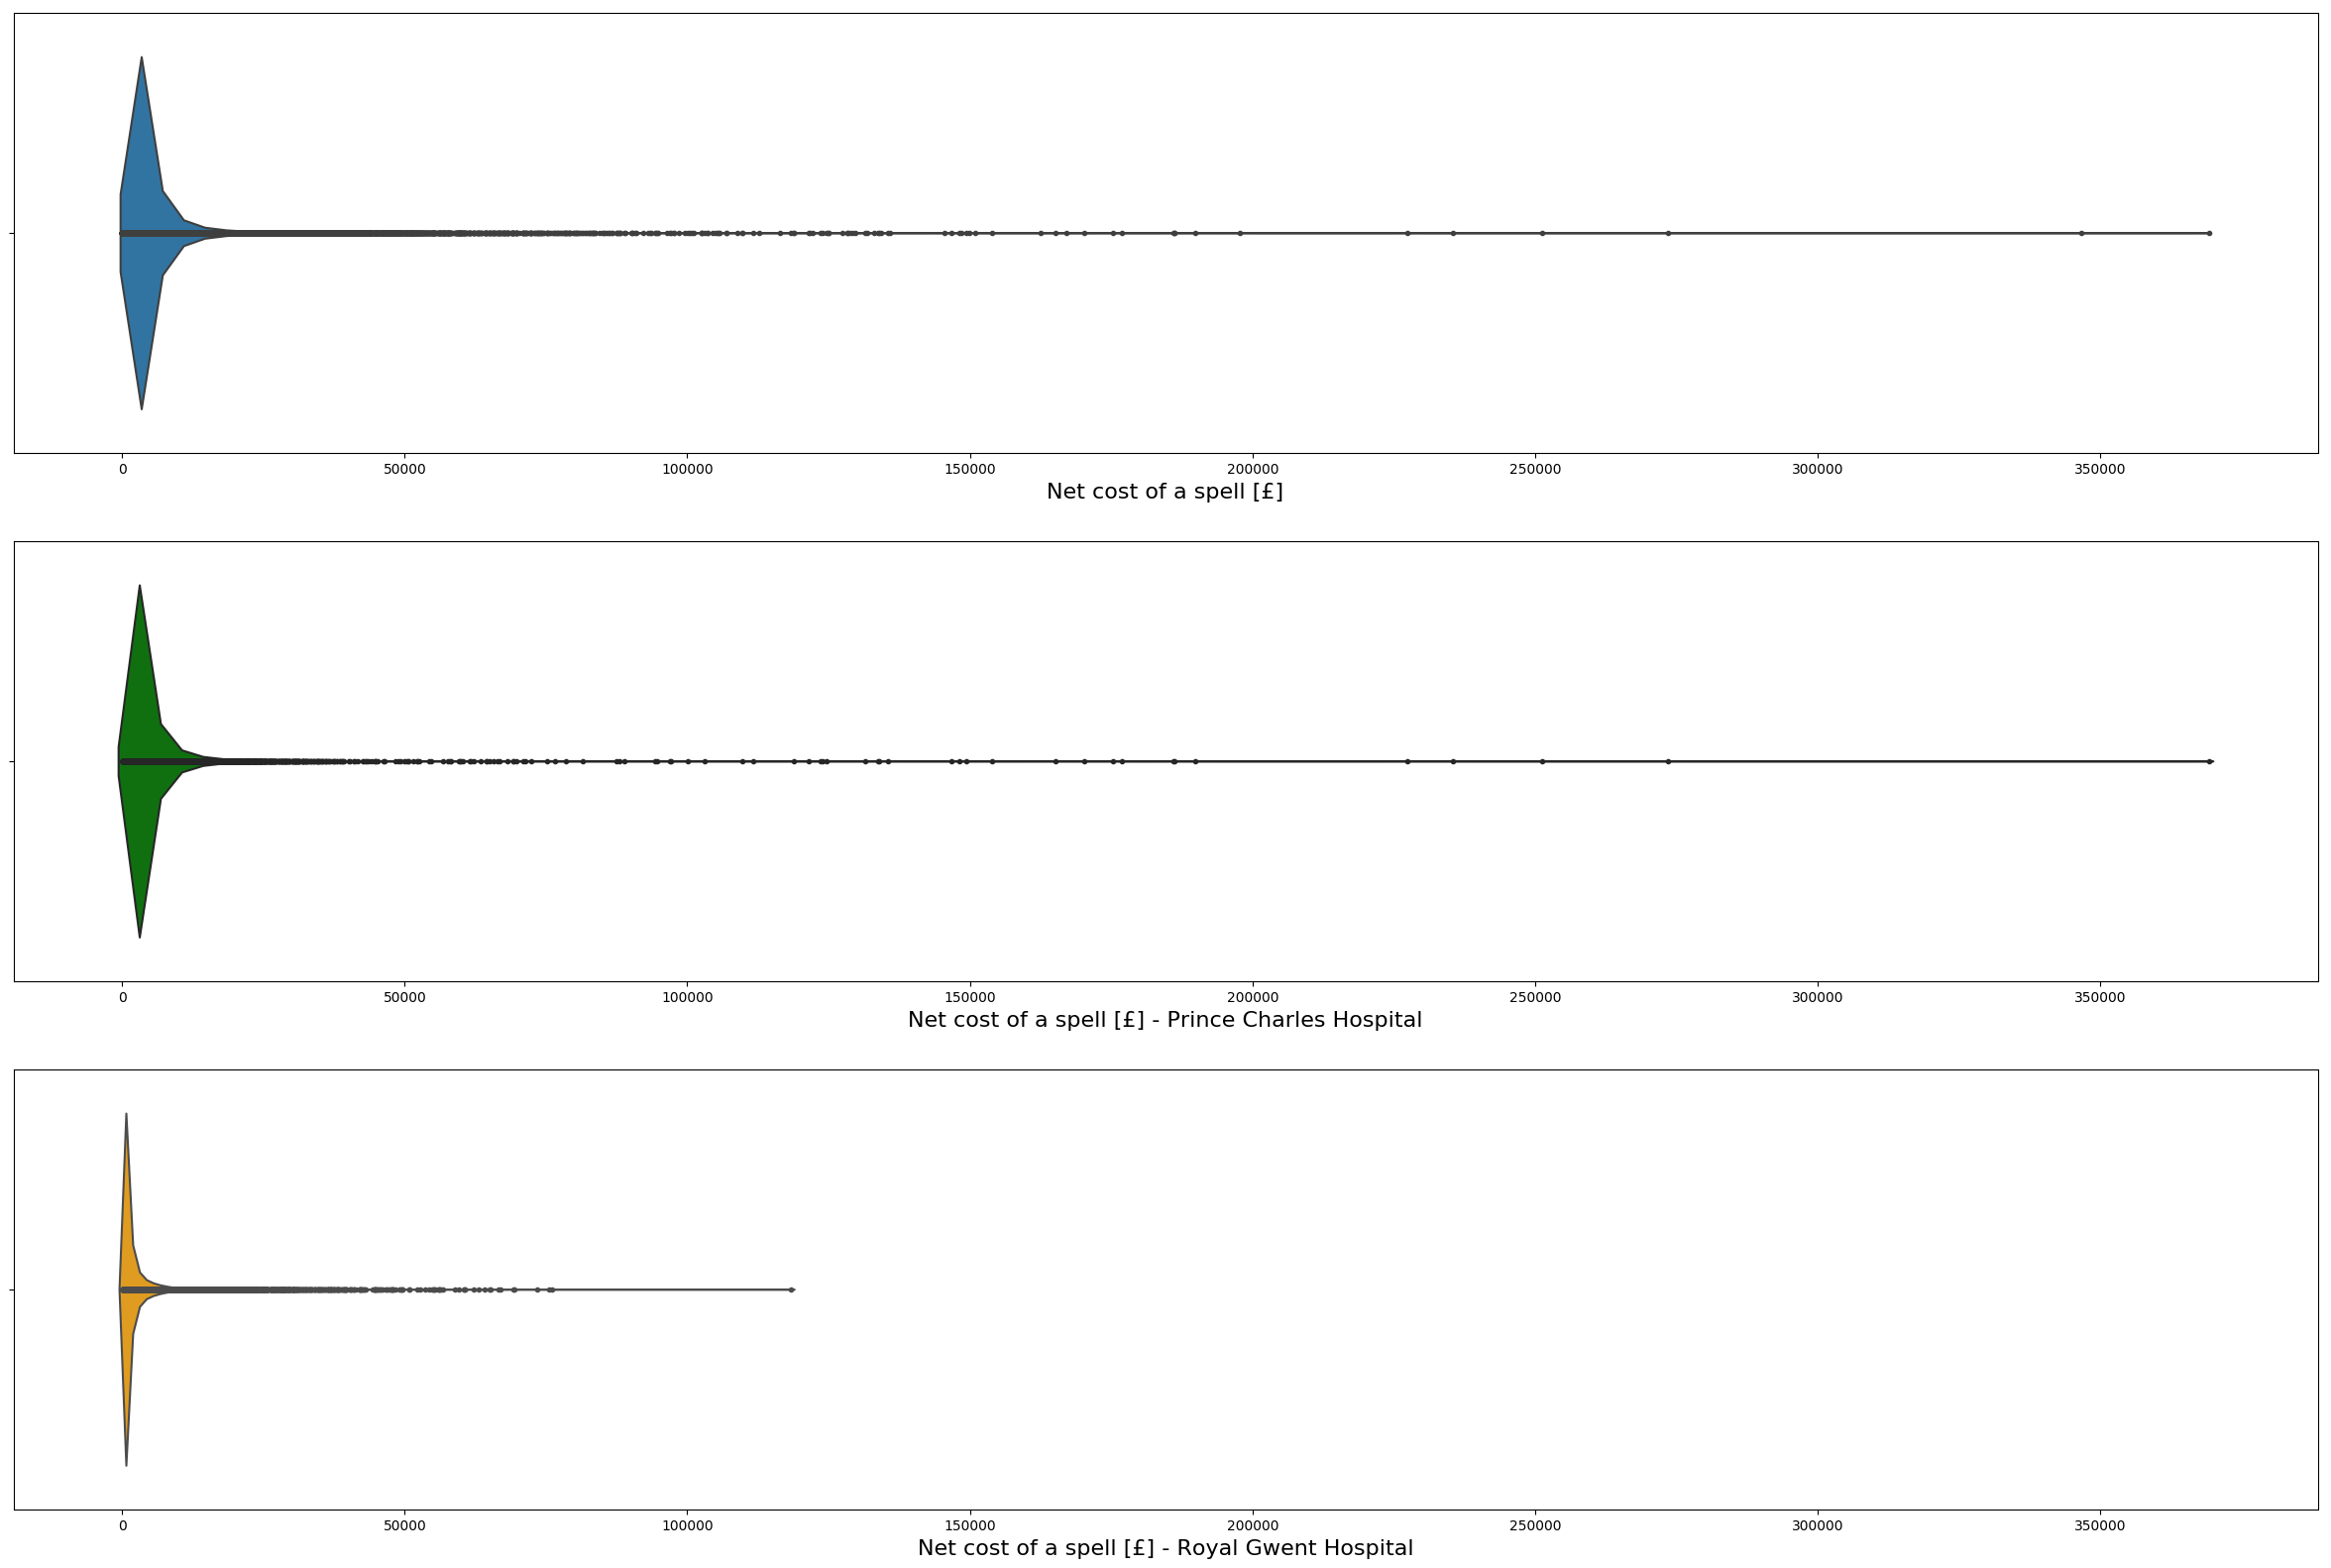

In [19]:
fig = plt.figure(figsize=(30,20), dpi=100)

ax1 = fig.add_subplot(3, 1, 1)
violin = df.groupby(['PATIENT_ID', 'SPELL_ID']).NetCost.sum()
sbn.violinplot(x=violin, inner='point')
plt.xlabel('Net cost of a spell [£]', size=16)

ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)
violin = df[df.site1 == 'PCH'].groupby(['PATIENT_ID', 'SPELL_ID']).NetCost.sum()
sbn.violinplot(x=violin, inner='point', color='green')
plt.xlabel('Net cost of a spell [£] - Prince Charles Hospital', size=16)

ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)
violin = df[df.site1 == 'RGH'].groupby(['PATIENT_ID', 'SPELL_ID']).NetCost.sum()
sbn.violinplot(x=violin, inner='point', color='orange')
plt.xlabel('Net cost of a spell [£] - Royal Gwent Hospital', size=16)

plt.savefig('../tex/img/Mean-NetCost-by-site.pdf');

# Correlation

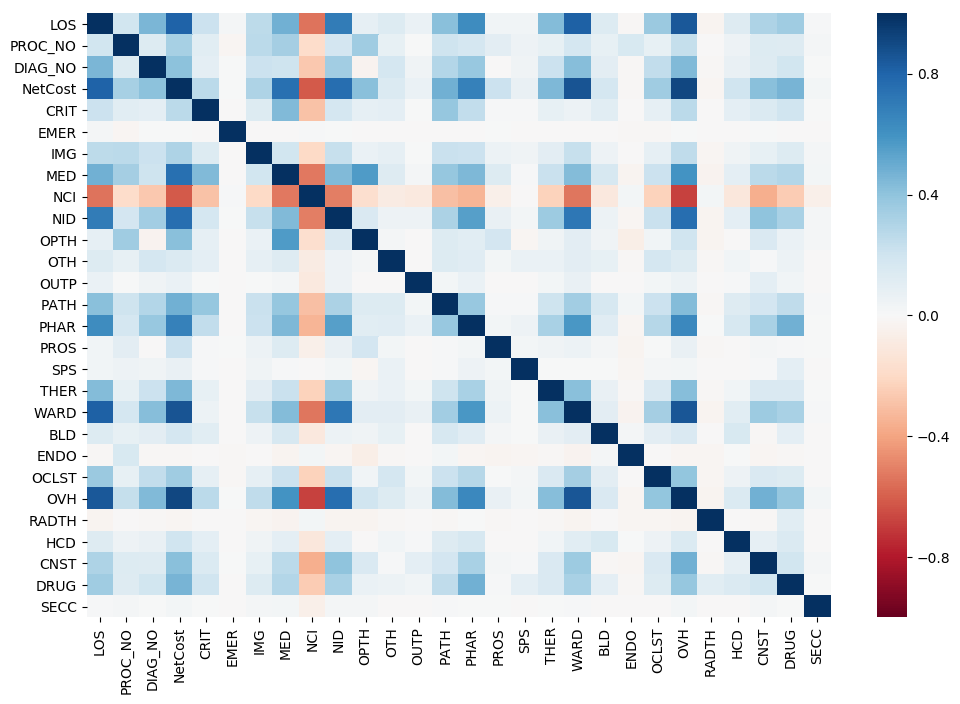

In [20]:
correlation_matrix = gb_data.corr()
plt.figure(figsize=(12,8), dpi=100)
sbn.heatmap(correlation_matrix, vmin=-1.0, cmap='RdBu')
plt.savefig('../tex/img/corr-heatmap.pdf');

In [21]:
covariances = gb_data.cov()
with open('../tex/covariances.tex', 'w') as f:
    f.write(covariances.to_latex())

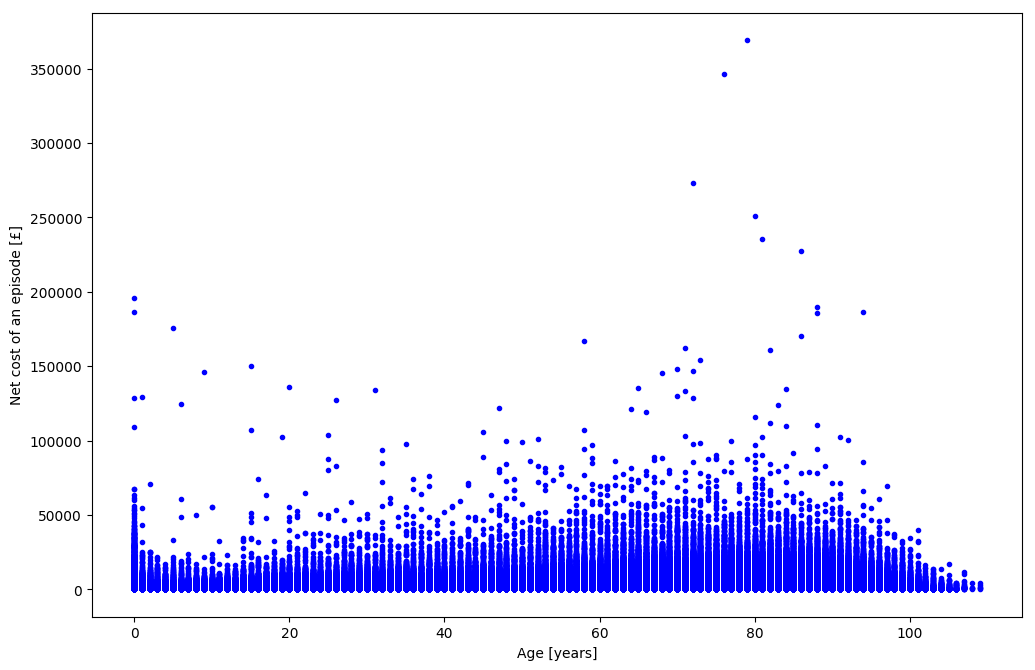

In [22]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(df.Age, df.NetCost, 'b.')
plt.xlabel('Age [years]')
plt.ylabel('Net cost of an episode [£]')
plt.savefig('../tex/img/Age-NetCost.pdf');

# Diabetes

In [9]:
diabetes_prim = (df.DiabetesPrim == '1.0')
diabetes_sec = (df.DiabetesSec == '1.0')
no_diabetes = (df.DiabetesPrim == '0.0') & (df.DiabetesSec == '0.0')

In [10]:
prim = len(df[diabetes_prim])
sec = len(df[diabetes_sec])
none = len(df[no_diabetes])
total = len(df)

percentages = [a / total * 100 for a in [prim, sec, none]]

In [11]:
diabetes = df[diabetes_prim | diabetes_sec]

In [26]:
diabetes.Age.describe()

count    264201.000000
mean         69.620599
std          15.593737
min           0.000000
25%          62.000000
50%          72.000000
75%          81.000000
max         107.000000
Name: Age, dtype: float64

In [12]:
non_diabetes = df[no_diabetes]

In [28]:
non_diabetes.Age.describe()

count    2.183274e+06
mean     5.206026e+01
std      2.618257e+01
min      0.000000e+00
25%      3.100000e+01
50%      5.600000e+01
75%      7.400000e+01
max      1.090000e+02
Name: Age, dtype: float64

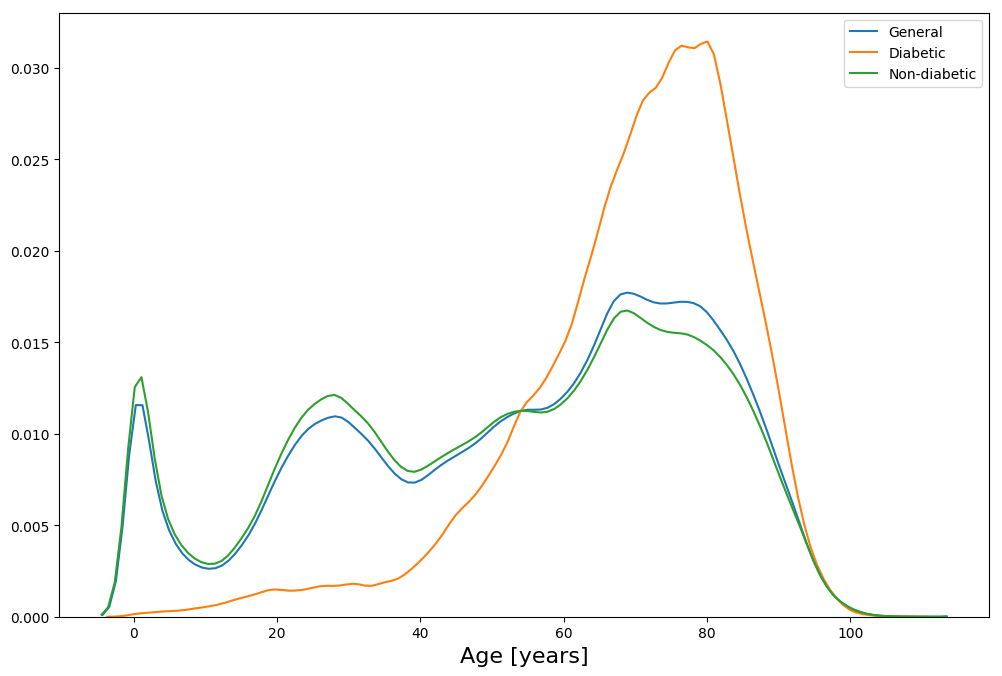

In [29]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df.Age, legend=False, label='General')
sbn.kdeplot(diabetes.Age, legend=False, label='Diabetic')
sbn.kdeplot(non_diabetes.Age, legend=False, label='Non-diabetic')
plt.xlabel('Age [years]', size=16)
plt.legend(loc='upper right')
plt.savefig('../tex/img/Diabetes-Age-kde.pdf');

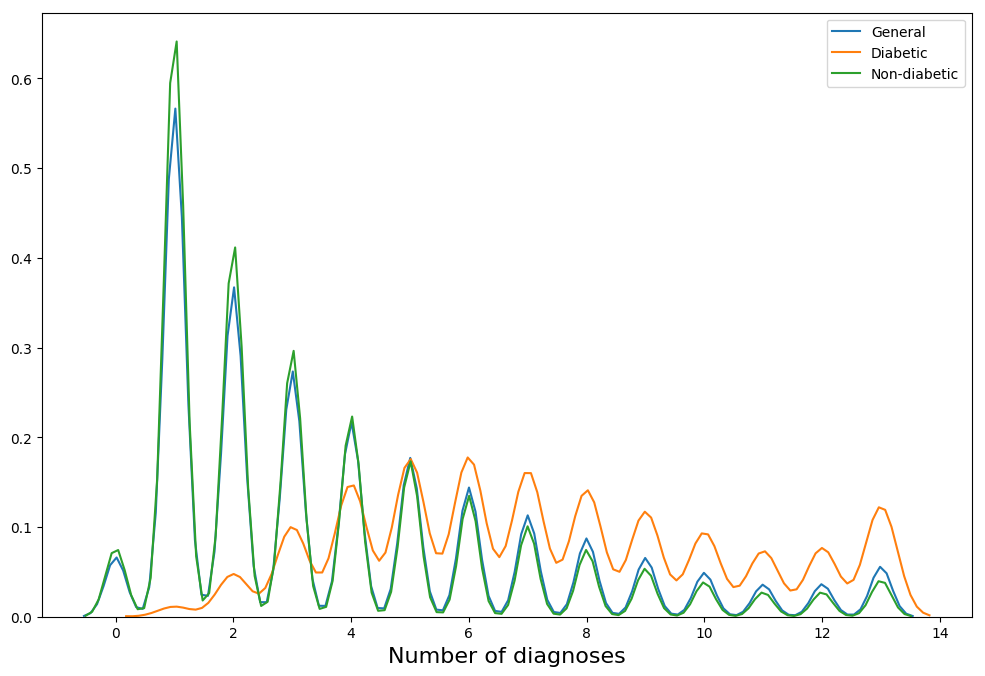

In [34]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df.DIAG_NO, legend=False, label='General')
sbn.kdeplot(diabetes.DIAG_NO, legend=False, label='Diabetic')
sbn.kdeplot(non_diabetes.DIAG_NO, legend=False, label='Non-diabetic')
plt.xlabel('Number of diagnoses', size=16)
plt.legend(loc='upper right')
plt.savefig('../tex/img/Diabetes-DIAG_NO-kde.pdf');

In [13]:
gb_diabetes = diabetes.groupby(['PATIENT_ID', 'SPELL_ID'])[['Bench_Period', 'LOS', 'PROC_NO', 'DIAG_NO'] + costs].sum()
gb_non_diabetes = non_diabetes.groupby(['PATIENT_ID', 'SPELL_ID'])[['Bench_Period', 'LOS', 'PROC_NO', 'DIAG_NO'] + costs].sum()

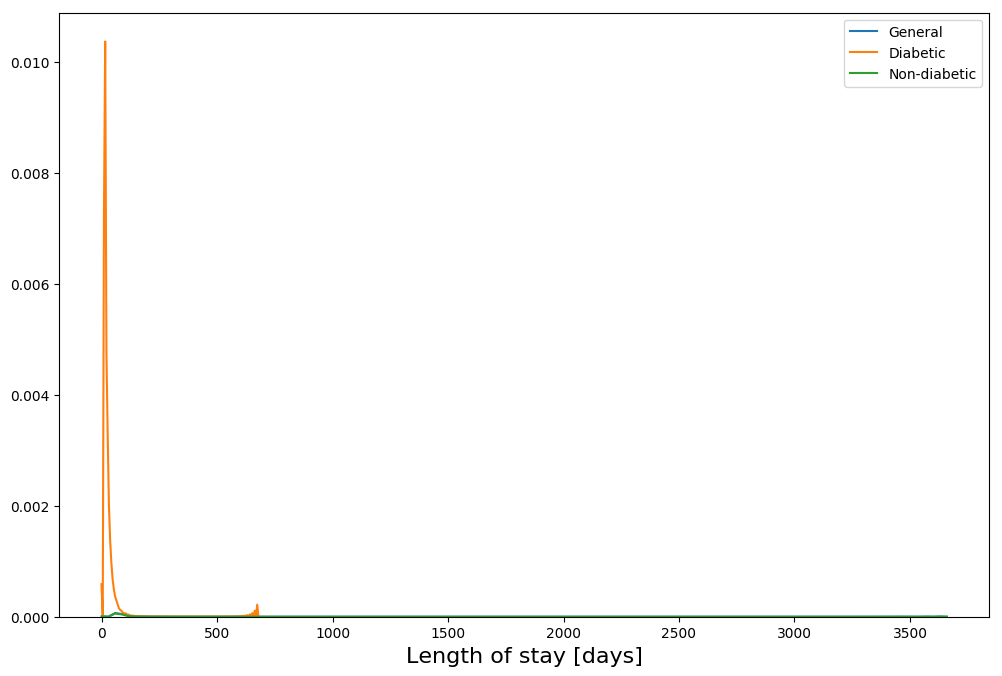

In [32]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(gb_data.LOS, legend=False, label='General')
sbn.kdeplot(gb_diabetes.LOS, legend=False, label='Diabetic')
sbn.kdeplot(gb_non_diabetes.LOS, legend=False, label='Non-diabetic')
plt.xlabel('Length of stay [days]', size=16)
plt.legend(loc='upper right')
plt.savefig('../tex/img/Diabetes-LOS-kde.pdf');

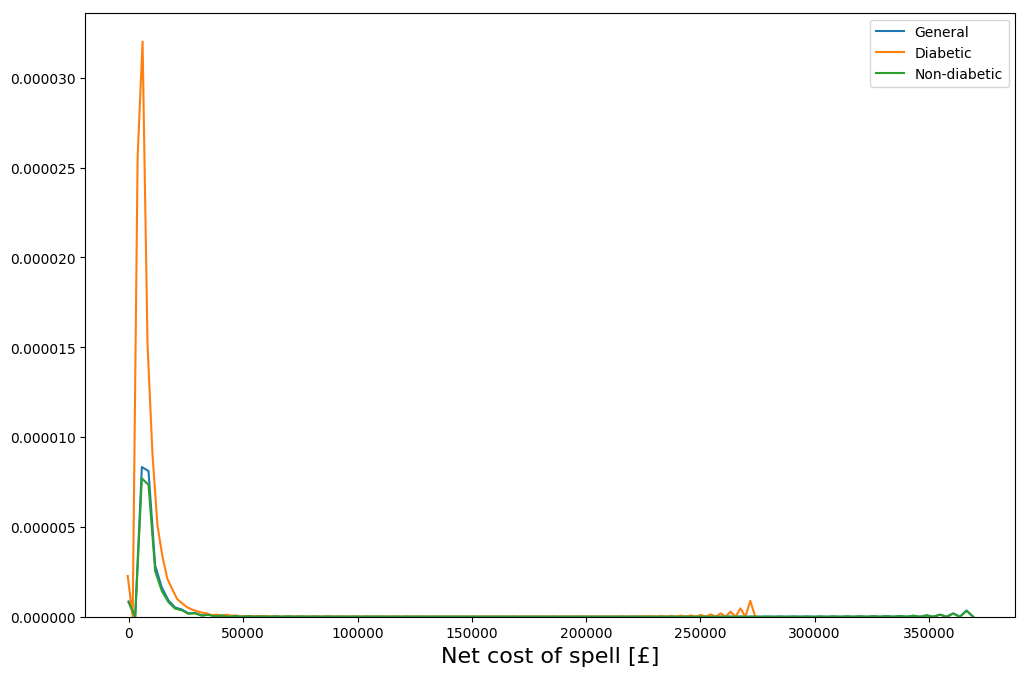

In [33]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(gb_data.NetCost, legend=False, label='General')
sbn.kdeplot(gb_diabetes.NetCost, legend=False, label='Diabetic')
sbn.kdeplot(gb_non_diabetes.NetCost, legend=False, label='Non-diabetic')
plt.xlabel('Net cost of spell [£]', size=16)
plt.legend(loc='upper right')
plt.savefig('../tex/img/Diabetes-NetCost-kde.pdf');

# Wards

In [15]:
same_ward = (df.start_ward == df.end_ward)
diff_ward = (df.start_ward != df.end_ward)

In [16]:
df[same_ward].Age.describe()

count    333132.000000
mean         50.999337
std          27.230510
min           0.000000
25%          29.000000
50%          56.000000
75%          74.000000
max         107.000000
Name: Age, dtype: float64

In [17]:
df[diff_ward].Age.describe()

count    2.114343e+06
mean     5.442169e+01
std      2.557754e+01
min      0.000000e+00
25%      3.400000e+01
50%      6.000000e+01
75%      7.500000e+01
max      1.090000e+02
Name: Age, dtype: float64

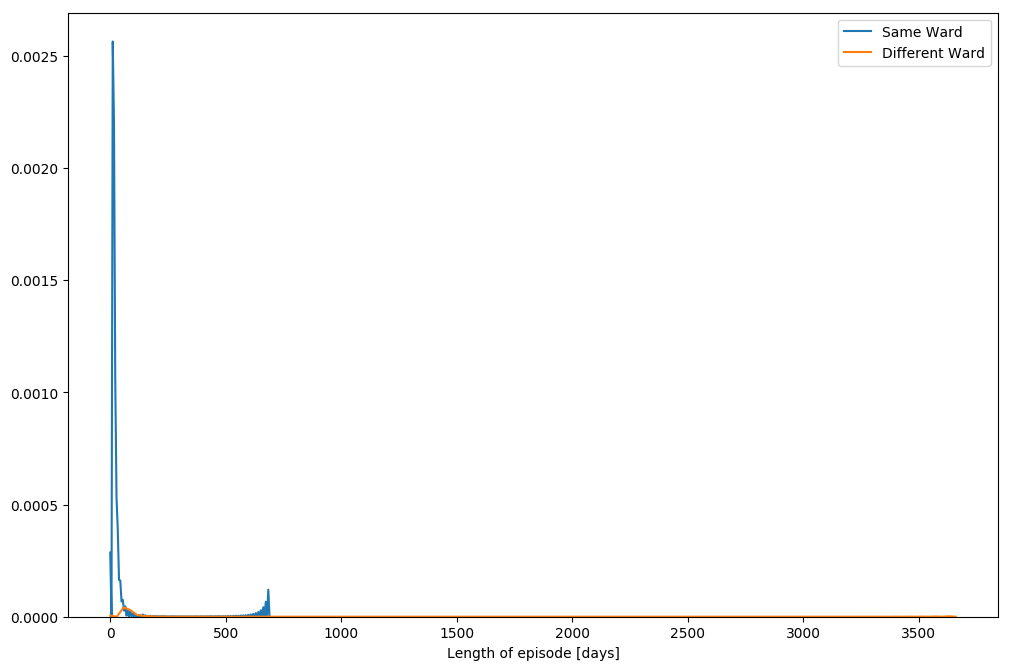

In [48]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df[same_ward].LOS, legend=False, label='Same Ward')
sbn.kdeplot(df[diff_ward].LOS, legend=False, label='Different Ward')
plt.xlabel('Length of episode [days]')
plt.legend(loc='upper right')
plt.savefig('../tex/img/Ward-LOS-kde.pdf');

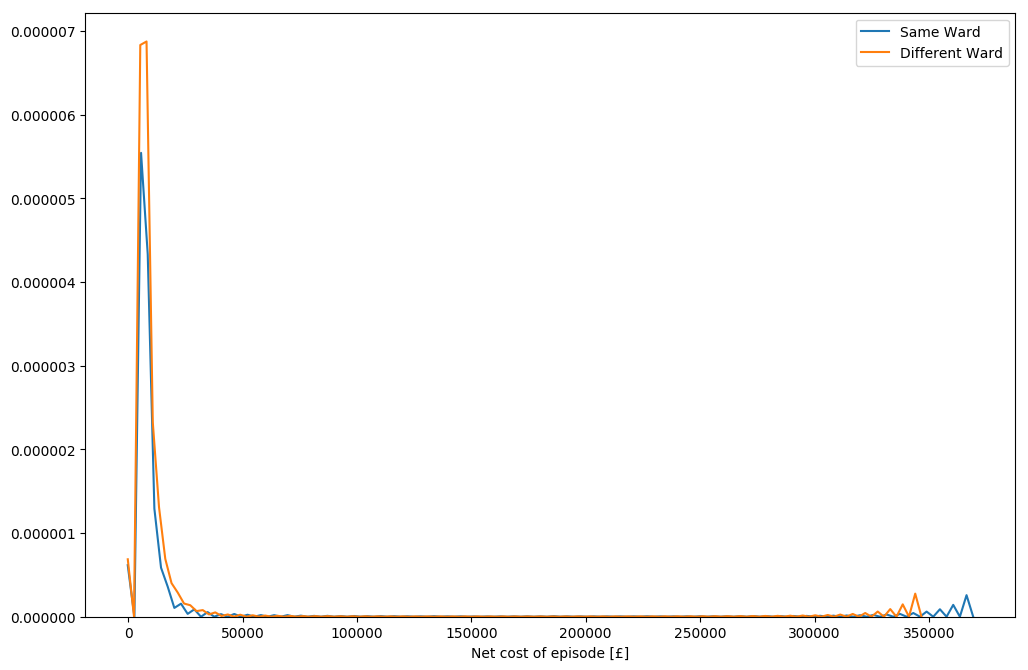

In [49]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df[same_ward].NetCost, legend=False, label='Same Ward')
sbn.kdeplot(df[diff_ward].NetCost, legend=False, label='Different Ward')
plt.xlabel('Net cost of episode [£]')
plt.legend(loc='upper right')
plt.savefig('../tex/img/Ward-NetCost-kde.pdf');

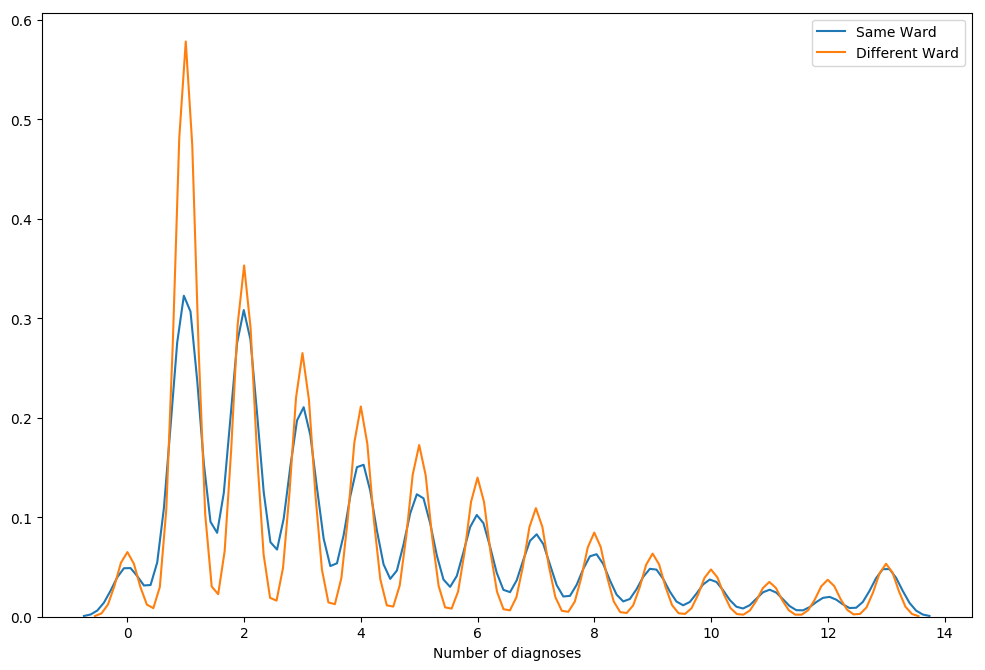

In [50]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df[same_ward].DIAG_NO, legend=False, label='Same Ward')
sbn.kdeplot(df[diff_ward].DIAG_NO, legend=False, label='Different Ward')
plt.xlabel('Number of diagnoses')
plt.legend(loc='upper right')
plt.savefig('../tex/img/Ward-DIAG_NO-kde.pdf');

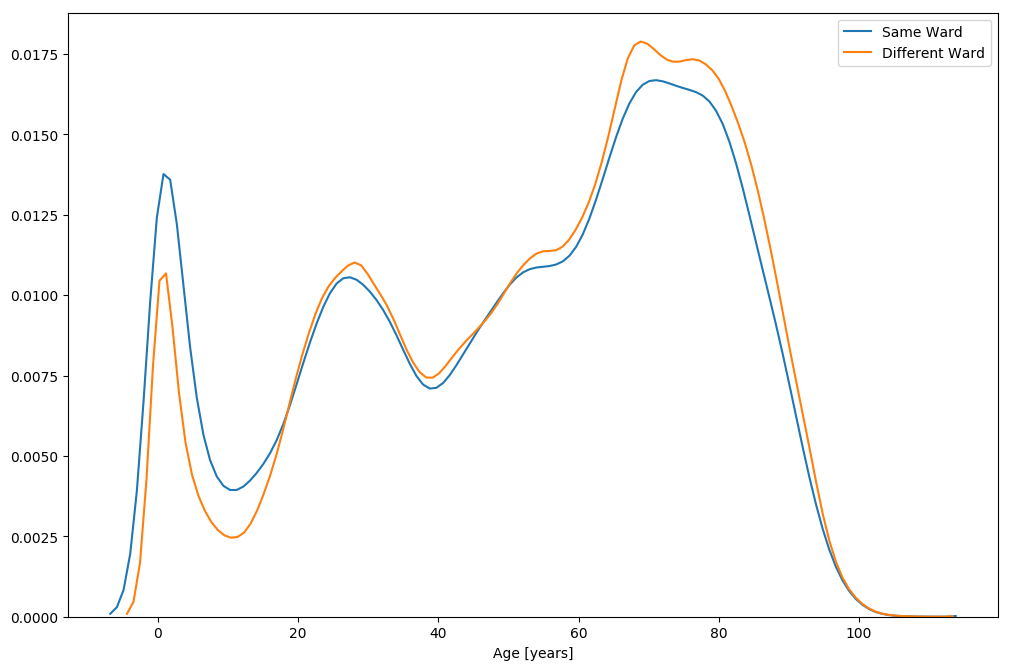

In [51]:
plt.figure(figsize=(12,8), dpi=100)
sbn.kdeplot(df[same_ward].Age, legend=False, label='Same Ward')
sbn.kdeplot(df[diff_ward].Age, legend=False, label='Different Ward')
plt.xlabel('Age [years]')
plt.legend(loc='upper right')
plt.savefig('../tex/img/Ward-Age-kde.pdf');